In [1]:
import sympy
from sympy import *
import pandas as pd
import subprocessf as sp
import os
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import ascii
from scipy.stats import linregress

#### TAKING THE IMAGES, CREATING TABLES, APLYNG FILTERS AND OBTAIN COORDINATES WITH ERRORS FOR 2 STARS AND ASTEROID

In [2]:
nombres = []
lista = []
i=0
for element in sorted(os.listdir()):
    if element.endswith('.FIT'):
        sp.run(['sex {} -c myconf.txt'.format(element)], shell=True, stderr = sp.DEVNULL)
        data = ascii.read("output.src")
        nombres.append(element)
        df = data.to_pandas()
        df = df[["X_IMAGE","Y_IMAGE", 'ERRX2_IMAGE', 'ERRY2_IMAGE']]
        df['Name'] = element
        df_s1 = df[(df['X_IMAGE'] >= 2400) & (df['X_IMAGE']<=2978) & (df['Y_IMAGE'] >= 600) & (df['Y_IMAGE']<=1100)] # hip105999
        df_s2 = df[(df['X_IMAGE'] >= 2000) & (df['X_IMAGE']<=2500) & (df['Y_IMAGE'] >= 1600) & (df['Y_IMAGE']<=2150)] # hd204296
        df_a = df[(df['X_IMAGE'] >= 300) & (df['X_IMAGE']<= 800) & (df['Y_IMAGE'] >= 700) & (df['Y_IMAGE']<= 950)]
        df2 = pd.concat([df_s1, df_s2, df_a], axis=0)        
        if len(df2) >= 3:
#            df2.to_csv('df{}.csv'.format(i), index=True)
            lista.append(df2)
            i +=1
for element in lista:
    element.iloc[0,-1] = element.iloc[0,-1].replace('asteroid.', '')
    element.iloc[0,-1] = element.iloc[0,-1].replace('.FIT', '')
    element.iloc[0,-1] = int(element.iloc[0,-1])
del lista[12]
#        output
#        if element.endswith('.src'):
#            nuevo_nombre = '{}.src'.format(element)
#            ruta_actual = os.path.join(ubicacion, nombre_actual)
#            ruta_nueva = os.path.join(ubicacion2, nuevo_nombre)
#            os.rename(ruta_actual,ruta_nueva)

#### TRASFORMATION'S PARAMETERS

In [3]:
#### CONSTANTS ####
delta_o = np.deg2rad(-(11 + 55/60 + 42.578247360/3600))
#### COORDENADAS ESTELARES DE CADA ESTRELLA ####
alpha_1p = np.deg2rad(15 * (21 + 28/60 + 05.0701102848/3600) * np.cos(delta_o))
delta_1 = np.deg2rad(-(11 + 55/60 + 42.578247360/3600))
delta_2 = np.deg2rad(-(11 + 49/60 + 33.054277188/3600))
alpha_2p = np.deg2rad(15 * (21 + 27/60 + 59.2109419296/3600) * np.cos(delta_o))
###############################################################################
lista_tetha = []
lista_lamvda = []
lista_alpha_p_o = []
lista_delta_p_o = []

for element in lista:
    x1 = element.iloc[0,0]
    x2 = element.iloc[1,0]
    y1 = element.iloc[0,1]
    y2 = element.iloc[1,1] 
    
    tetha = np.arctan((delta_1-delta_2)/(alpha_1p-alpha_2p)) - np.arctan((y1-y2)/(x1-x2)) #delta_o declinacion que nosotros quieramos
    lamvda = np.sqrt((alpha_1p-alpha_2p)**2+(delta_1-delta_2)**2)/np.sqrt((y1-y2)**2+(x1-x2)**2) 
    alpha_p_o = -lamvda*np.cos(tetha)*x1 + lamvda*np.sin(tetha)*y1 + alpha_1p
    delta_p_o = -lamvda*np.sin(tetha)*x1 - lamvda*np.cos(tetha)*y1 + delta_1
    
    element['tetha'] = 0.0
    element.iloc[0,-1] = tetha

    element['lamvda'] = 0.0
    element.iloc[0,-1] = lamvda
    
    element['alpha_p_o'] = 0.0
    element.iloc[0,-1] = alpha_p_o
    
    element['delta_p_o'] = 0.0
    element.iloc[0,-1] = delta_p_o

In [16]:
lamvda

()

#### TRANSFORMATION OF ASTEROID'S COORDINATES FROM CARTESIAN (X,Y) TO ANGULAR (ALPHA', DELTA')

In [5]:
asteroide = pd.DataFrame(columns = ['alpha_o','delta'])
alpha = []
delta = []
for element in lista:
    X_a = element.iloc[2,0]
    Y_a = element.iloc[2,1]
    alpha_p_a = element.iloc[0,-3] * (X_a * np.cos(element.iloc[0,-4]) - Y_a * np.sin(element.iloc[0,-4])) + element.iloc[0,-2]
    delta_a = element.iloc[0,-3] * (X_a * np.sin(element.iloc[0,-4]) + Y_a * np.cos(element.iloc[0,-4])) + element.iloc[0,-1]
    alpha.append(alpha_p_a)
    delta.append(delta_a)
asteroide['alpha_o'] = alpha/np.cos(delta_o)######### no estaba dividido por np.cos(delta_o)
asteroide['delta'] = delta
#asteroide.plot('alpha_o', 'delta')
#asteroide.plot('delta', 'alpha_o')

#### TIME OF EACH IMAGE

In [6]:
deltatime = ((58*60)+9.180-(9*60)-28.498)/53
ddeltatime = 0.1
for element in lista:
    element.iloc[0,4] = (element.iloc[0,4] - 42) * deltatime
lista
tiempo = []
for element in lista:
    tiempo.append(element.iloc[0,4])
asteroide['Tiempo'] = pd.Series(tiempo)
asteroide

,alpha_o,delta,Tiempo
0,5.616816,-0.207525,0.000000
1,5.616820,-0.207525,110.214415
2,5.616822,-0.207525,165.321623
3,5.616828,-0.207522,220.428830
4,5.616829,-0.207521,275.536038
5,5.616832,-0.207521,330.643245
6,5.616837,-0.207516,385.750453
7,5.616844,-0.207518,440.857660
8,5.616840,-0.207519,495.964868
9,5.616842,-0.207517,551.072075


#### LINEAR FIT AND PLOT FOR RIGHT ASCENSION

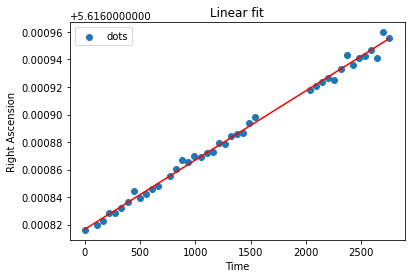

Velocity = 5.029010624270063e-08 rad/sec
Velocity error = 5.69983215990058e-10
Intersect = 5.6168166579195695
Intersect error = 9.080112654171598e-07
Adj coef = 0.9975044540756207


In [7]:
coeficientes, matriz_cov = np.polyfit(asteroide['Tiempo'], asteroide['alpha_o'], 1, cov = True)
coef_adj = np.corrcoef(asteroide['Tiempo'], asteroide['alpha_o'])[0,1]
m_alpha,b_alpha = coeficientes


error_m_alpha = np.sqrt(matriz_cov[0,0])
error_b_alpha = np.sqrt(matriz_cov[1,1])

y_ajustada = m_alpha * asteroide['Tiempo'] + b_alpha

plt.scatter(asteroide['Tiempo'], asteroide['alpha_o'], label = 'dots')
plt.plot(np.array(asteroide['Tiempo']), np.array(y_ajustada), color = 'red')
plt.xlabel('Time')
plt.ylabel('Right Ascension')
plt.legend()
plt.title('Linear fit')
plt.show()
print('Velocity =',m_alpha,'rad/sec')
print('Velocity error =',error_m_alpha)
print('Intersect =',b_alpha)
print('Intersect error =',error_b_alpha)
print('Adj coef =',coef_adj)
#Velocity = 5.029010624270063e-08 rad/sec
#Velocity error = 5.69983215990058e-10
#Intersect = 5.6168166579195695
#Intersect error = 9.080112654171598e-07
#Adj coef = 0.9975044540756207

#### LINEAR FIT AND PLOT FOR DECLINATION

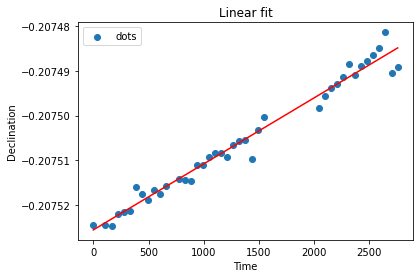

Velocity = 1.4764898406185424e-08 rad/sec
Velocity error = 3.782975943021569e-10
Intersect = -0.20752554868894127
Intersect error = 6.026466528666352e-07
Adj coef = 0.9874397557723523


In [8]:
coeficientes, matriz_cov = np.polyfit(asteroide['Tiempo'], asteroide['delta'], 1, cov = True)
coef_adj = np.corrcoef(asteroide['Tiempo'], asteroide['delta'])[0,1]
m_delta,b_delta = coeficientes


error_m_delta = np.sqrt(matriz_cov[0,0])
error_b_delta = np.sqrt(matriz_cov[1,1])

y_ajustada = m_delta * asteroide['Tiempo'] + b_delta

plt.scatter(asteroide['Tiempo'], asteroide['delta'], label = 'dots')
plt.plot(np.array(asteroide['Tiempo']), np.array(y_ajustada), color = 'red')
plt.xlabel('Time')
plt.ylabel('Declination')
plt.legend()
plt.title('Linear fit')
plt.show()
print('Velocity =',m_delta,'rad/sec')
print('Velocity error =',error_m_delta)
print('Intersect =',b_delta)
print('Intersect error =',error_b_delta)
print('Adj coef =',coef_adj)
#Velocity = 1.4764898406185424e-08 rad/sec
#Velocity error = 3.782975943021569e-10
#Intersect = -0.20752554868894127
#Intersect error = 6.026466528666352e-07
#Adj coef = 0.9874397557723523

#### TRAJECTORY OF THE ASTEROID

##### Earth's velocity respect to sun

In [9]:
from astropy.constants import G, au, M_sun
s_modulus = au.value
M = M_sun.value
G = G.value
alpha_sun = np.deg2rad(15*(16 + 28/60 + 40.4/3600))
delta_sun = np.deg2rad(-(21 + 46/60 + 40.9/3600))
s_vector = s_modulus * np.array((np.cos(alpha_sun)*np.cos(delta_sun), np.sin(alpha_sun)*np.cos(delta_sun), np.sin(delta_sun)), float)
k_versor = np.array((0, -np.sin(np.deg2rad(23+26/60+21/3600)), np.cos(np.deg2rad(23+26/60+21/3600))), float) #direccion perpendicular a la ecliptica
velocity_e_s = np.sqrt(G*M/(s_modulus**3)) * (np.cross(s_vector, k_versor))
print('La velocidad de la tierra respecto al sol es', velocity_e_s)
s_vector
#La velocidad de la tierra respecto al sol es [-27783.89088382   9846.74515846   4269.06109227]
#S_vector = array([-5.39047465e+10, -1.28036191e+11, -5.55025671e+10])

La velocidad de la tierra respecto al sol es [-27783.89088382   9846.74515846   4269.06109227]


array([-5.39047465e+10, -1.28036191e+11, -5.55025671e+10])

##### Simbolic resolution of the 2 equations system to obtain distance and velocity of the asteroid from earth

In [10]:
d, ud = symbols('d ud') # radial direction from the earth and velocity in the radial direction from the earth
x = d * cos(asteroide['alpha_o'][0]) * cos(asteroide['delta'][0])
y = d * sin(asteroide['alpha_o'][0]) * cos(asteroide['delta'][0])
z = d * sin(asteroide['delta'][0])

sx = s_modulus * cos(alpha_sun) * cos(delta_sun)
sy = s_modulus * sin(alpha_sun) * cos(delta_sun)
sz = s_modulus * sin(delta_sun)

ui = -y * m_alpha - z * cos(asteroide['alpha_o'][0]) * m_delta + cos(asteroide['alpha_o'][0]) * cos(asteroide['delta'][0]) * ud  #geocentric velocity in x
uj =  x * m_alpha - z * sin(asteroide['alpha_o'][0]) * m_delta + sin(asteroide['alpha_o'][0]) * cos(asteroide['delta'][0]) * ud  #geocentric velocity in y
uk =  d * cos(asteroide['delta'][0]) * m_delta + sin(asteroide['delta'][0]) * ud  #geocentric velocity in z

s_vec = Matrix([sx, sy, sz])

d_vector = Matrix([x, y, z])
r_vector = s_vec - d_vector ###### d_vector - s_vec

v_a_s = Matrix([ui, uj, uk]) + Matrix(velocity_e_s)
v_a_s_norma = v_a_s.dot(v_a_s)
r_vector_norma = r_vector.dot(r_vector)

eq1 = r_vector.dot(v_a_s)
eq2 = r_vector_norma * (v_a_s_norma)**2 - (G*M)**2

In [11]:
v_a_s

Matrix([
[3.28104721572539e-8*d + 0.769205198245634*ud - 27783.8908838171],
[   3.6802959297599e-8*d - 0.604873232742594*ud + 9846.745158461],
[1.44481020274656e-8*d - 0.206038188944232*ud + 4269.06109226838]])

In [12]:
sol = solve((eq1), (ud), dict=True)
sol

[{ud: 2.5e-8*(-141735535871237.0*d**2 + 1.04622389076646e+41*d - 5.27543621646135e+36)/(1.25e+29*d - 5.92718775731367e+39)}]

In [13]:
expand(eq1)##esto es solo para ver como queda

3.30872245021211e-24*d**2 - 1.0*d*ud + 20924.4778153292*d + 47417502058.5092*ud

In [14]:
eqnew = fraction(simplify(eq2.subs(ud,1.0e-7*(-214199366135143.0*d**2 + 1.00296139674268e+41*d - 5.27543621646135e+36)/(4.99999999999999e+29*d - 3.15070116174883e+40))))[0]

In [15]:
sol2 = solve(eqnew, d)#, check=True, numerical=True, simplify=True, force=True, rational=True, quick=True)s
sol2

KeyboardInterrupt: 

In [ ]:
print('La distancia asteroide-tierra (d) es =',sol2[3]/s_modulus,'au')

##### Orbit's parameter

In [ ]:
#asteroid sun orbit radius
r_vector = r_vector.subs(d, sol2[3])
orbit_radius = r_vector.dot(r_vector)
orbit_radius
#asteroid velocity respoect to sun
v_a_s = v_a_s.subs(d, sol2[3])
vel_a_e = (sol[0][ud]).subs(d, sol2[3])
v_a_s = v_a_s.subs(ud, vel_a_e)
v_a_s_mod = v_a_s.norm()
print(v_a_s_mod)
print(float(r_vector.norm())/s_modulus)

In [ ]:
#n vector perperndicular to the asteroid-sun orbit plane
n_vector = v_a_s.cross(r_vector)
n_versor = n_vector/n_vector.norm()
n_versor

In [ ]:
#inclination between earth-sun and asteroid-sun orbits
k_versor = Matrix(k_versor)
inclination = acos(k_versor.dot(n_versor))
inclination_deg = float(deg(inclination))
print(inclination,'rad')
print(inclination_deg,'deg')
print('horizon table 3.831600358837806 deg')

In [ ]:
#ascending node and longitude of ascending node
asc_node_versor = k_versor.cross(n_versor)/sin(inclination)
vernal_point = Matrix([1,0,0])
asc_node_long = acos(vernal_point.dot(asc_node_versor)) #tenemos que elegir el valor negativo de acos porque la comoponente y del vector es negativa
asc_node_long_deg = np.rad2deg(float(-asc_node_long))
print(asc_node_long,'rad')
print(360+asc_node_long_deg,'deg')
print(asc_node_versor)
print('horizon table 283.2129733452493 deg')